# 示例：涡扇发动机-端到端-剩余使用寿命预测
- 参考论文：Deep Convolutional Neural Network Based Regression Approach for Estimation of Remaining Useful Life
- 数据集：CMAPSS、PHM2008
- 模型：CNN、2维卷积
- 输入：矩阵，使用滑动窗口提取（窗口大小：15、步长：1）
- 输出（RUL）：分段线性RUL（piece-wise linear degradation model），根据窗口最后一行计算RUL
- 损失函数：均方误差- 优化算法：随机梯度下降

In [1]:
import numpy as np
import torch
from torch import nn

from rulframework.data.Dataset import Dataset
from rulframework.data.FeatureExtractorStream import FeatureExtractorStream
from rulframework.data.labeler.RulTurbofanLabeler import RulTurbofanLabeler
from rulframework.data.loader.turbofan.CMAPSSLoader import CMAPSSLoader
from rulframework.data.processor.NormalizationProcessor import NormalizationProcessor
from rulframework.entity.Turbofan import Turbofan
from rulframework.metric.Evaluator import Evaluator
from rulframework.metric.degeneration.MSE import MSE
from rulframework.metric.end2end.MAE import MAE
from rulframework.metric.end2end.NASAScore import NASAScore
from rulframework.metric.end2end.PHM2012Score import PHM2012Score
from rulframework.metric.end2end.PercentError import PercentError
from rulframework.metric.end2end.RMSE import RMSE
from rulframework.model.pytorch.PytorchModel import PytorchModel
from rulframework.util.Plotter import Plotter

## 定义：论文提出的模型

In [2]:
class ProposedModel(nn.Module):
    def __init__(self, feature_size):
        super(ProposedModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(feature_size, 4))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=14, kernel_size=(1, 3))
        self.pool = nn.AvgPool2d(kernel_size=(1, 2), stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(28, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = torch.sigmoid(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.sigmoid(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

## 定义：必要组件
- 数据加载器，获取原始数据
- 标签器，用于生成训练数据和测试数据
- 需要去掉的恒定特征

In [3]:
data_loader = CMAPSSLoader('D:\\data\\dataset\\CMAPSSData')
labeler = RulTurbofanLabeler(window_size=15, window_step=1, max_rul=125)
columns_to_drop = [0, 1, 2, 3, 4, 8, 9, 13, 19, 21, 22]
feature_size = 14

DEBUG - 15:11:20 >> 
<< Root directory of dataset: D:\data\dataset\CMAPSSData
	FD001_test, location: D:\data\dataset\CMAPSSData\test_FD001.txt
	FD002_test, location: D:\data\dataset\CMAPSSData\test_FD002.txt
	FD003_test, location: D:\data\dataset\CMAPSSData\test_FD003.txt
	FD004_test, location: D:\data\dataset\CMAPSSData\test_FD004.txt
	FD001_train, location: D:\data\dataset\CMAPSSData\train_FD001.txt
	FD002_train, location: D:\data\dataset\CMAPSSData\train_FD002.txt
	FD003_train, location: D:\data\dataset\CMAPSSData\train_FD003.txt
	FD004_train, location: D:\data\dataset\CMAPSSData\train_FD004.txt


## 定义：按工况批量加载发动机数据

In [4]:
def batch_load(trajectory: str) -> [Turbofan]:
    
    entity_name_list = []
    entities = []

    for i in range(1, CMAPSSLoader.trajectories[trajectory] + 1):
        entity_name_list.append(trajectory + '_' + str(i))

    for name in entity_name_list:
        entities.append(data_loader(name, columns_to_drop))

    t_min = np.delete(data_loader.arr_min[trajectory], columns_to_drop)
    t_max = np.delete(data_loader.arr_max[trajectory], columns_to_drop)
    p = NormalizationProcessor(arr_min=t_min, arr_max=t_max)
    feature_extractor = FeatureExtractorStream([p])

    for entity in entities:
        feature_extractor(entity)

    return entities

## 生成训练数据

In [5]:
turbofans_train = batch_load('FD001_train')
train_set = Dataset()
for turbofan in turbofans_train:
    train_set.append(labeler(turbofan))

INFO - 15:11:20 >> Loading data entity: FD001_train_1
INFO - 15:11:20 >> Successfully loaded data entity: FD001_train_1
INFO - 15:11:20 >> Loading data entity: FD001_train_2
INFO - 15:11:20 >> Successfully loaded data entity: FD001_train_2
INFO - 15:11:20 >> Loading data entity: FD001_train_3
INFO - 15:11:20 >> Successfully loaded data entity: FD001_train_3
INFO - 15:11:20 >> Loading data entity: FD001_train_4
INFO - 15:11:20 >> Successfully loaded data entity: FD001_train_4
INFO - 15:11:20 >> Loading data entity: FD001_train_5
INFO - 15:11:20 >> Successfully loaded data entity: FD001_train_5
INFO - 15:11:20 >> Loading data entity: FD001_train_6
INFO - 15:11:20 >> Successfully loaded data entity: FD001_train_6
INFO - 15:11:20 >> Loading data entity: FD001_train_7
INFO - 15:11:20 >> Successfully loaded data entity: FD001_train_7
INFO - 15:11:20 >> Loading data entity: FD001_train_8
INFO - 15:11:20 >> Successfully loaded data entity: FD001_train_8
INFO - 15:11:20 >> Loading data entity: 

## 生成测试数据

In [6]:
turbofan_test = batch_load('FD001_test')
test_set = Dataset()
for turbofan in turbofan_test:
    test_set.append(labeler(turbofan))

INFO - 15:11:21 >> Loading data entity: FD001_test_1
INFO - 15:11:21 >> Successfully loaded data entity: FD001_test_1
INFO - 15:11:21 >> Loading data entity: FD001_test_2
INFO - 15:11:21 >> Successfully loaded data entity: FD001_test_2
INFO - 15:11:21 >> Loading data entity: FD001_test_3
INFO - 15:11:21 >> Successfully loaded data entity: FD001_test_3
INFO - 15:11:21 >> Loading data entity: FD001_test_4
INFO - 15:11:21 >> Successfully loaded data entity: FD001_test_4
INFO - 15:11:21 >> Loading data entity: FD001_test_5
INFO - 15:11:21 >> Successfully loaded data entity: FD001_test_5
INFO - 15:11:21 >> Loading data entity: FD001_test_6
INFO - 15:11:21 >> Successfully loaded data entity: FD001_test_6
INFO - 15:11:21 >> Loading data entity: FD001_test_7
INFO - 15:11:21 >> Successfully loaded data entity: FD001_test_7
INFO - 15:11:21 >> Loading data entity: FD001_test_8
INFO - 15:11:21 >> Successfully loaded data entity: FD001_test_8
INFO - 15:11:21 >> Loading data entity: FD001_test_9
INF

## 定义模型并训练

INFO - 15:11:22 >> 
<< Successfully initialized model:
	device: cuda
	dtype: torch.float32
INFO - 15:11:22 >> Start training model...
DEBUG - 15:11:22 >> Epoch 1/120, Loss: 7052.5603091591
DEBUG - 15:11:22 >> Epoch 2/120, Loss: 4364.5658794202
DEBUG - 15:11:23 >> Epoch 3/120, Loss: 2924.2861520868
DEBUG - 15:11:23 >> Epoch 4/120, Loss: 2209.6316897744
DEBUG - 15:11:23 >> Epoch 5/120, Loss: 1894.4531394557
DEBUG - 15:11:23 >> Epoch 6/120, Loss: 1770.3372866982
DEBUG - 15:11:23 >> Epoch 7/120, Loss: 1741.1896667480
DEBUG - 15:11:23 >> Epoch 8/120, Loss: 1728.7944576866
DEBUG - 15:11:23 >> Epoch 9/120, Loss: 1722.6979354055
DEBUG - 15:11:24 >> Epoch 10/120, Loss: 1717.6968303480
DEBUG - 15:11:24 >> Epoch 11/120, Loss: 1716.3446462531
DEBUG - 15:11:24 >> Epoch 12/120, Loss: 1724.4966045179
DEBUG - 15:11:25 >> Epoch 13/120, Loss: 1724.3333772358
DEBUG - 15:11:25 >> Epoch 14/120, Loss: 1715.9620521947
DEBUG - 15:11:25 >> Epoch 15/120, Loss: 1721.5538458573
DEBUG - 15:11:26 >> Epoch 16/120, L

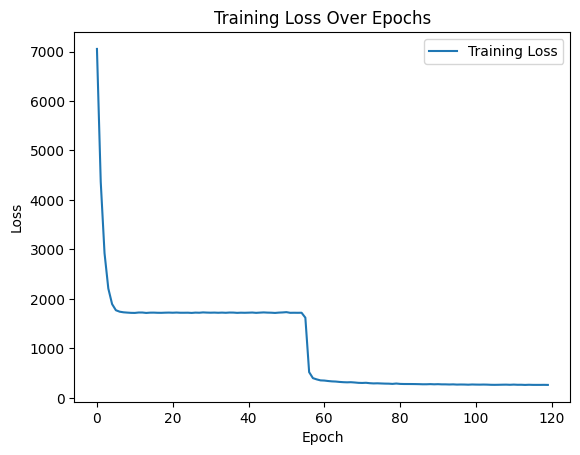

'Training Loss Over Epochs'

In [7]:
model = PytorchModel(ProposedModel(feature_size))
model.train(train_set, epochs=120, batch_size=256, lr=0.01)
Plotter.loss(model)

## 做出预测

In [8]:
result = model.test(test_set)

## 预测结果评价

In [9]:
test_set.name = 'FD001_test'
evaluator = Evaluator()
evaluator.add(MAE(), MSE(), RMSE(), PercentError(), PHM2012Score(), NASAScore())
evaluator(test_set, result)

INFO - 15:12:05 >> 
<< Performance evaluation of FD001_test:
	MAE: 31.0109
	MSE: 1462.8570
	RMSE: 38.2473
	Percent Error: -145.99%
	PHM2012 Score: 0.2370
	NASA Score: 4625075.5511


{'MAE': '31.0109',
 'MSE': '1462.8570',
 'RMSE': '38.2473',
 'Percent Error': '-145.99%',
 'PHM2012 Score': '0.2370',
 'NASA Score': '4625075.5511'}

## 出图：涡扇发动机（原始数据）

INFO - 15:12:05 >> Loading data entity: FD001_train_1
INFO - 15:12:05 >> Successfully loaded data entity: FD001_train_1


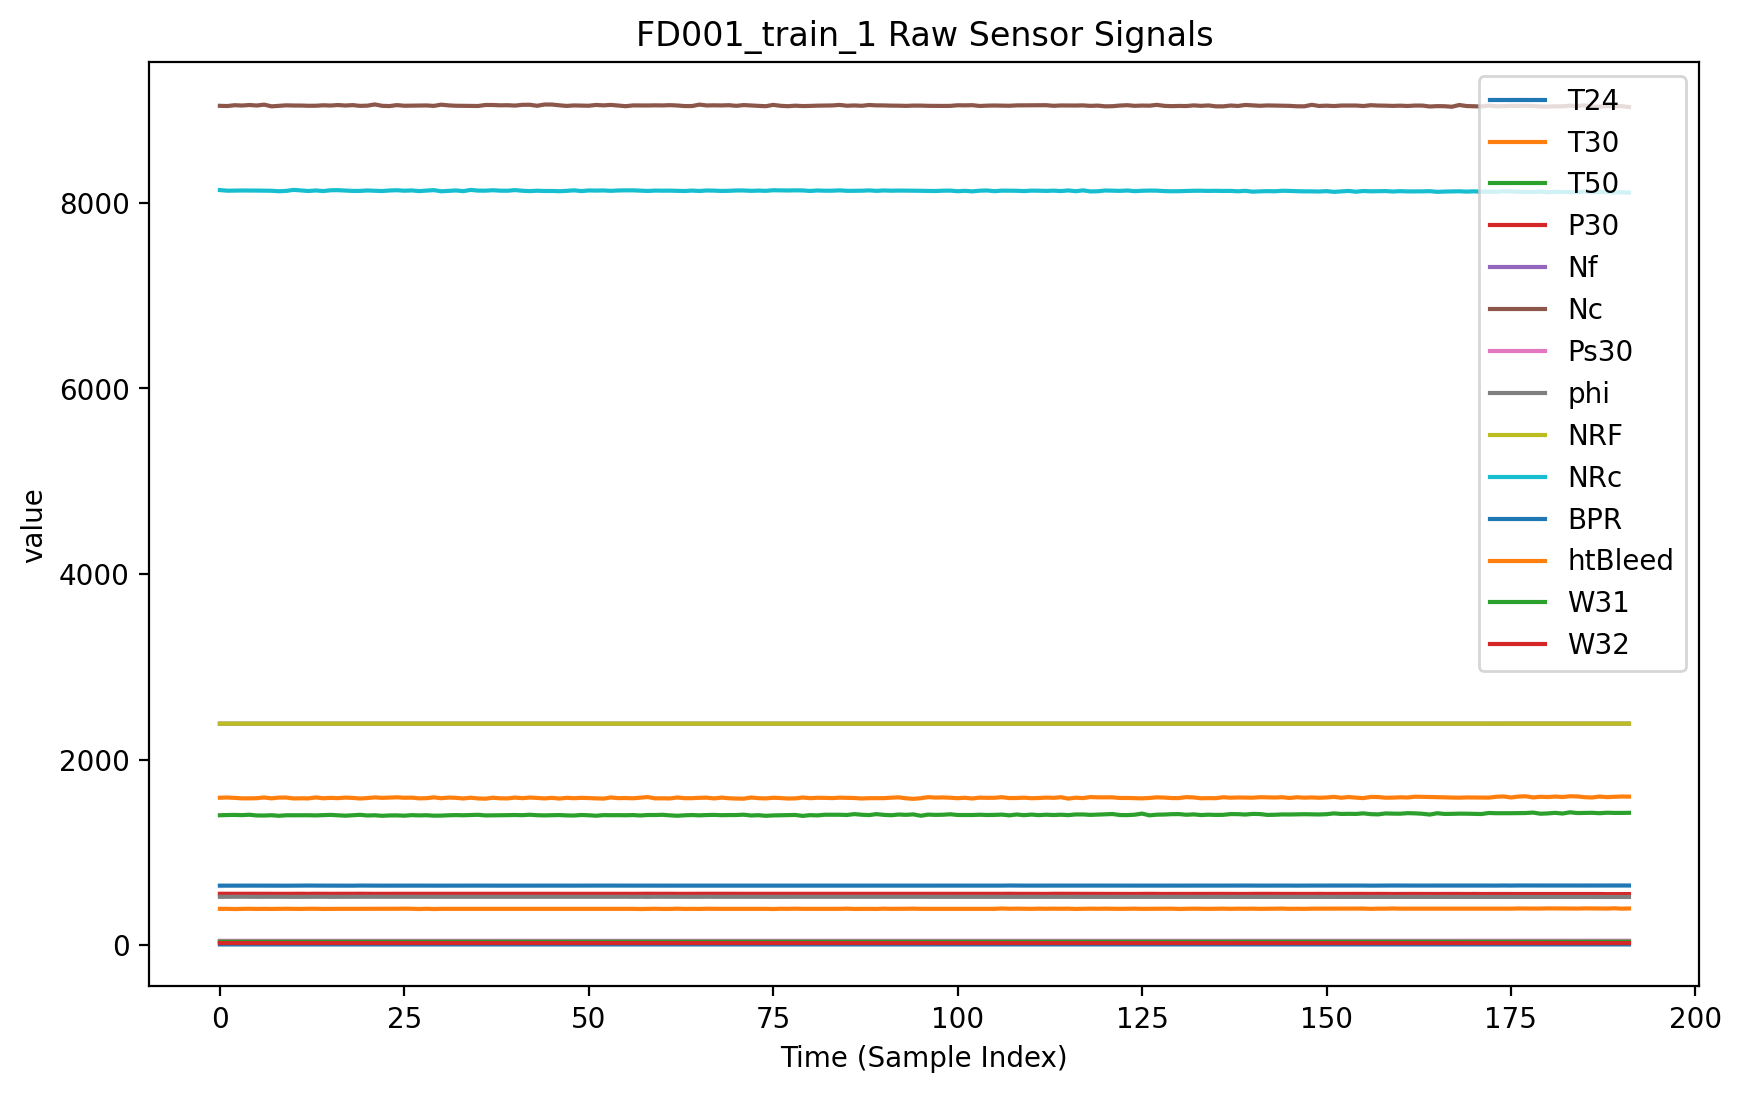

'FD001_train_1 Raw Sensor Signals'

In [10]:
turbofan = data_loader('FD001_train_1',columns_to_drop)
Plotter.raw(turbofan)

## 出图：涡扇发动机（归一化数据）

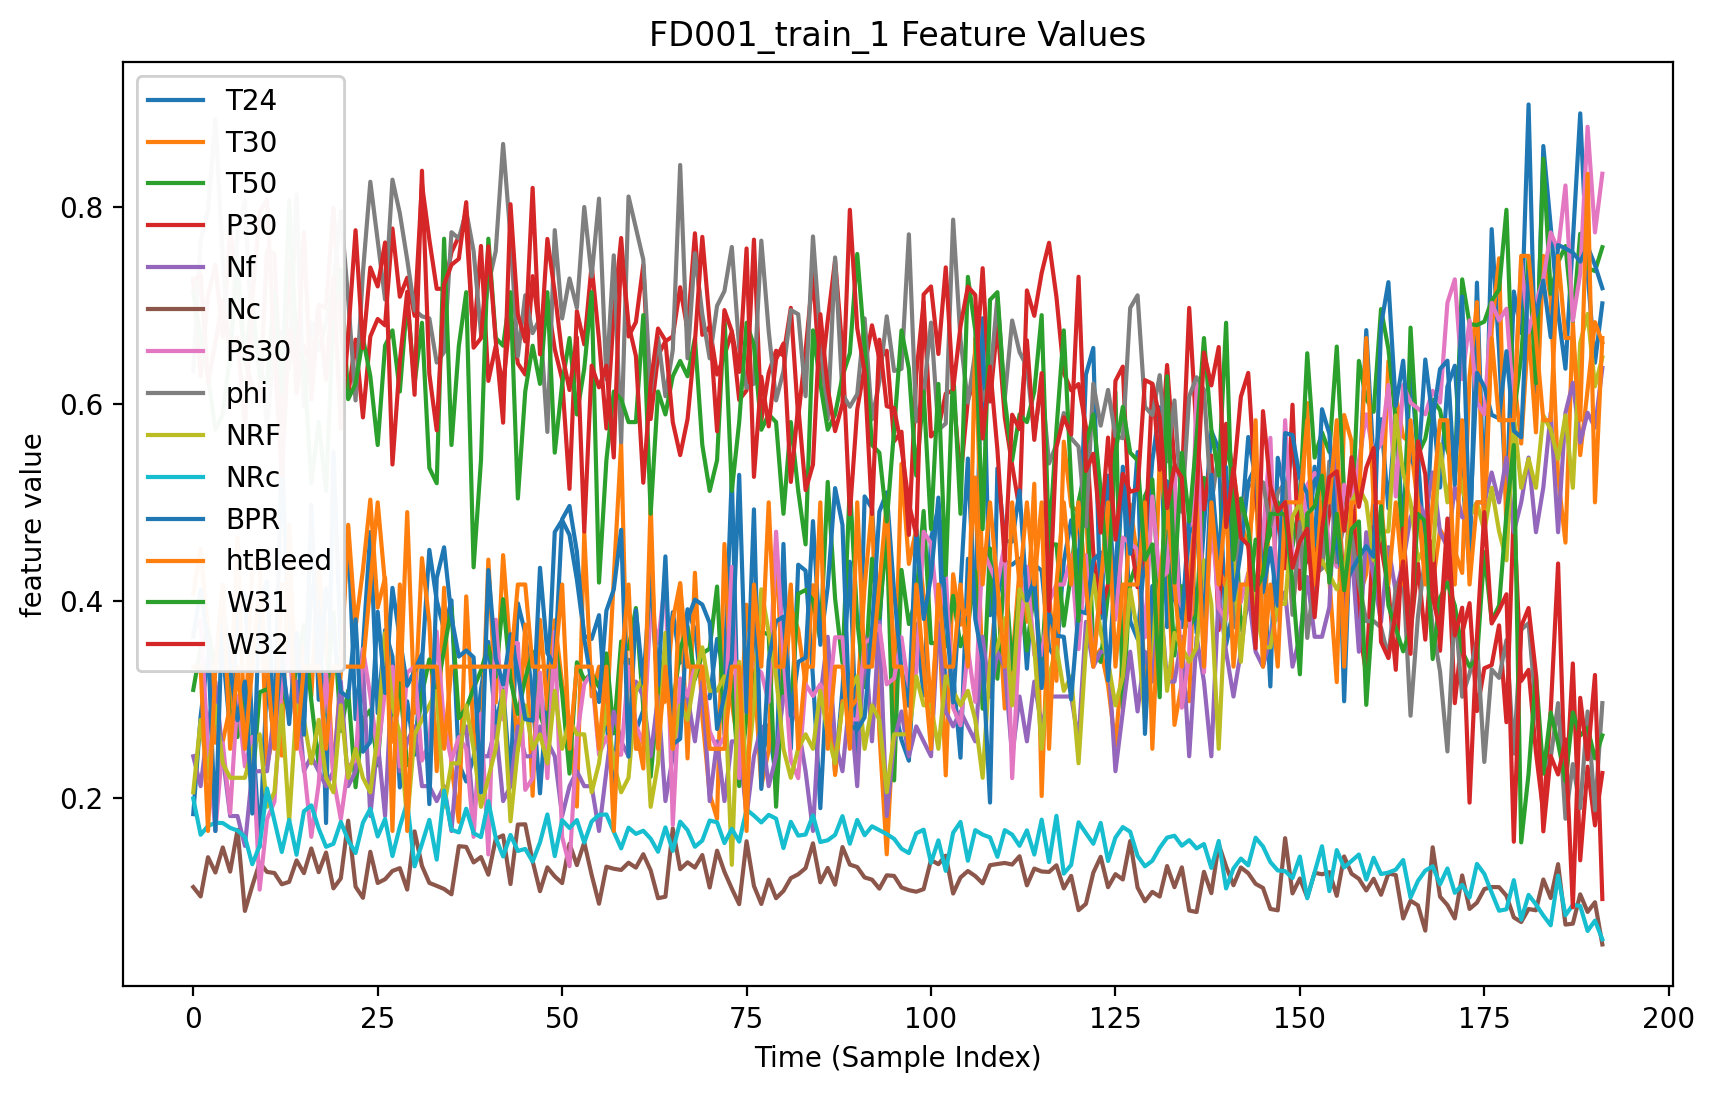

'FD001_train_1 Feature Values'

In [11]:
t_min = np.delete(data_loader.arr_min['FD001_train'], columns_to_drop)
t_max = np.delete(data_loader.arr_max['FD001_train'], columns_to_drop)
p = NormalizationProcessor(arr_min=t_min, arr_max=t_max)
feature_extractor = FeatureExtractorStream([p])
feature_extractor(turbofan)
Plotter.feature(turbofan)

## 出图：预测结果（单个涡扇发动机）

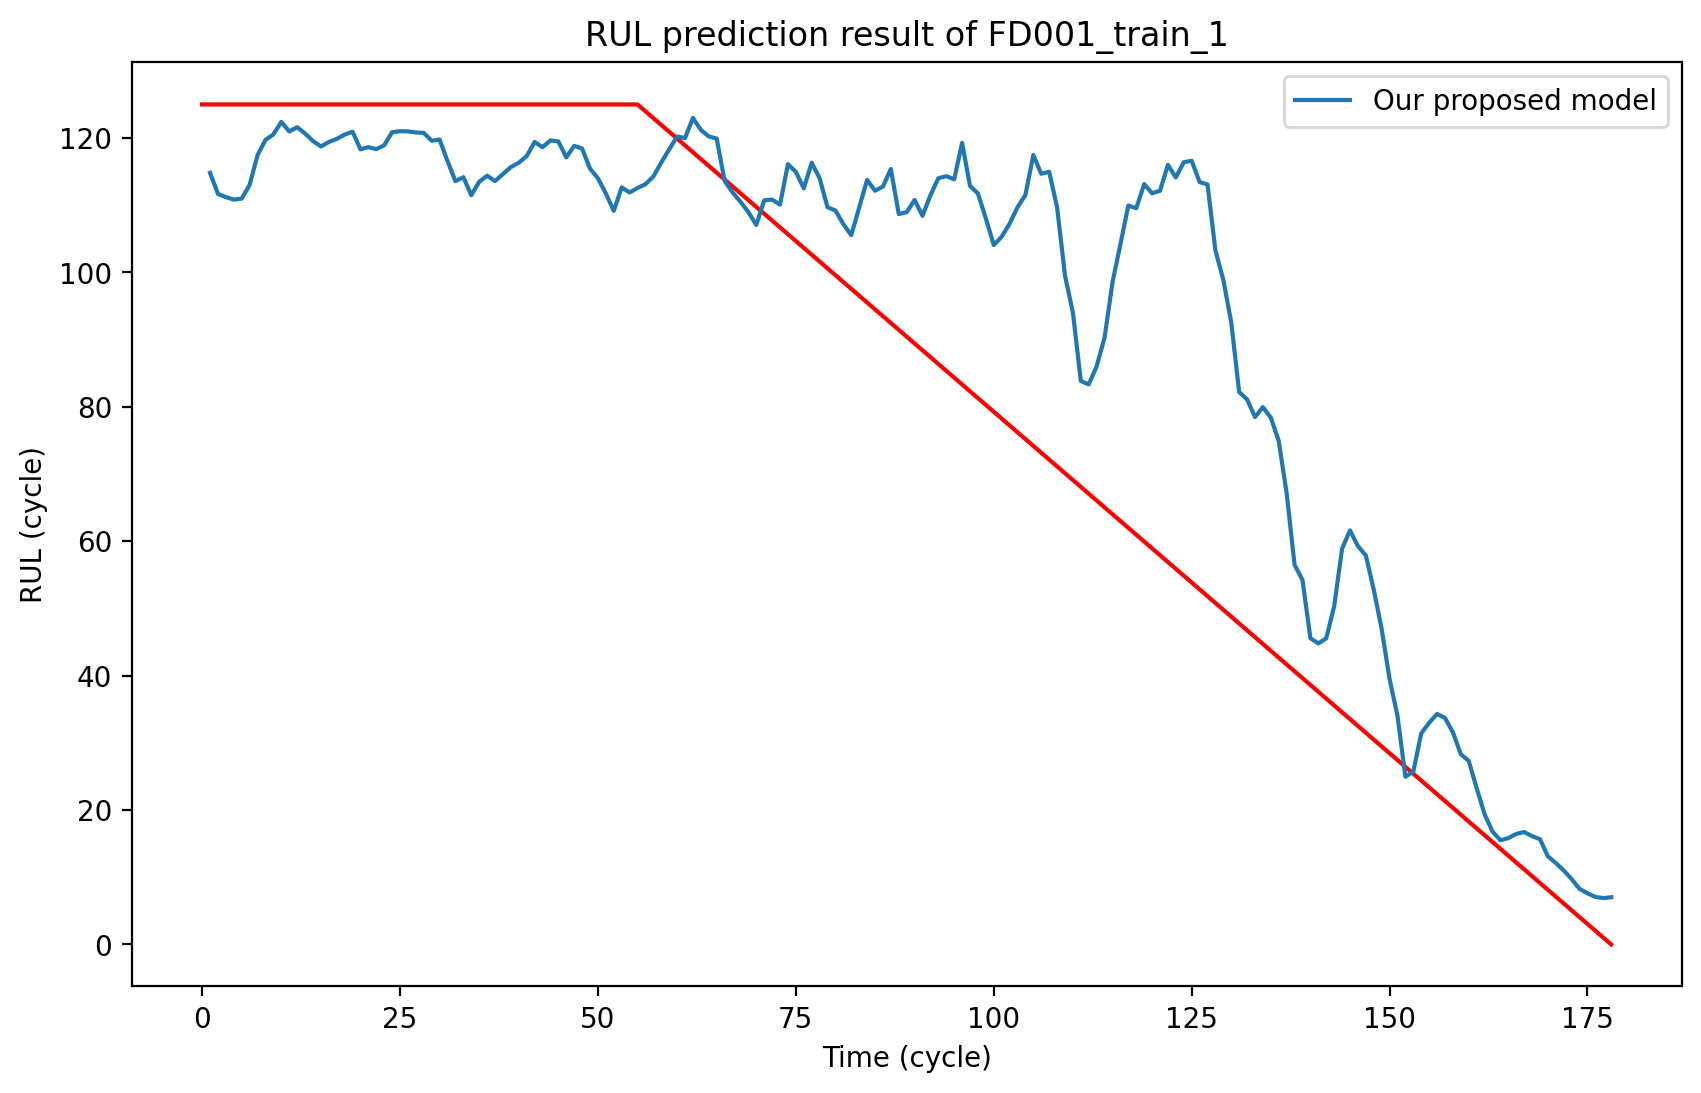

'RUL prediction result of FD001_train_1'

In [12]:
a_test = labeler(turbofan)
result = model.test(a_test)
Plotter.rul_end2end(a_test, result, is_scatter=False, label_x='Time (cycle)', label_y='RUL (cycle)')